In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

<h1>Customer 2011</h1>

In [3]:
# Starting dataset
df = pd.read_csv('D:/Desktop/DataMining/Customer_2011_subset_2.csv', sep=',', index_col=0)
df

,avgSpent,Nsessions,Max,Min,DistinctItem,avgItemSession,MaxSessionsMonth,MeanTimeGap
Customer ID,,,,,,,,
12347.0,51.731667,6,92.67,13.54,82,275.333333,10,55.600000
12348.0,0.850000,2,0.85,0.85,2,22.000000,5,99.000000
12349.0,200.750000,1,200.75,200.75,64,547.000000,11,0.000000
12350.0,25.300000,1,25.30,25.30,16,196.000000,2,0.000000
12352.0,30.644286,7,53.20,12.55,50,71.714286,9,44.666667
...,...,...,...,...,...,...,...,...
18281.0,5.460000,1,5.46,5.46,5,52.000000,12,0.000000
18282.0,11.925000,2,13.08,10.77,8,25.500000,5,85.000000
18283.0,70.714375,16,124.18,1.25,259,84.562500,11,20.733333


<h3>Correlation Matrix</h3>

<p>We begin by examining the correlations between the attributes of the dataset to be clustered in order to identify the highly correlated couples.
Dropping redundant attributes benefits the analysis by reducing the dimensionality of the dataset and rising the influence that more useful feature could have on the whole clustering process</p>

In [4]:
mat = df.corr()

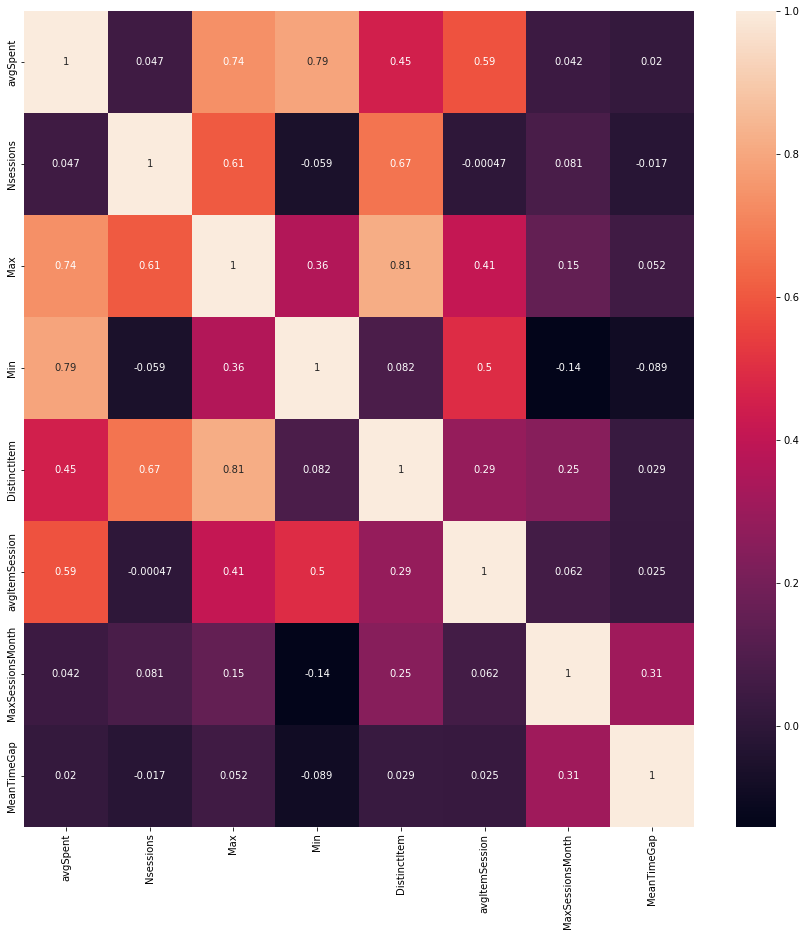

In [5]:
fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(mat, annot=True)
plt.show()

<p>We fix a maximum threshold value in order to identify highly correlated features and subsequently drop them</p>

In [6]:
corr_threshold = 0.9
print("Att. A\tAtt. B\tCorr(A,B)")
for i in range(0, len(df.columns)):
    for j in range(i+1, len(df.columns)):
        corr = df[df.columns[i]].corr(df[df.columns[j]])
        if  corr > corr_threshold:
            print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

Att. A	Att. B	Corr(A,B)


In [7]:
df.dtypes

avgSpent            float64
Nsessions             int64
Max                 float64
Min                 float64
DistinctItem          int64
avgItemSession      float64
MaxSessionsMonth      int64
MeanTimeGap         float64
dtype: object

<p>
Despite the high correlation among the others attributes we decide not to eliminate the attribute due to their relevance within the whole grouping process.</p>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4082 entries, 12347.0 to 18300.0
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avgSpent          4082 non-null   float64
 1   Nsessions         4082 non-null   int64  
 2   Max               4082 non-null   float64
 3   Min               4082 non-null   float64
 4   DistinctItem      4082 non-null   int64  
 5   avgItemSession    4082 non-null   float64
 6   MaxSessionsMonth  4082 non-null   int64  
 7   MeanTimeGap       4082 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 287.0 KB


<h3>Normalization</h3>

<p>Normalization of data to avoid the dominance - bias- of attributes with an higher magnitude with respect to others.</p>

In [9]:
minmax_scaler = MinMaxScaler()
df_norm_minmax = minmax_scaler.fit_transform(df.values)

In [10]:
ndf = pd.DataFrame(df_norm_minmax, columns=df.columns)
ndf

,avgSpent,Nsessions,Max,Min,DistinctItem,avgItemSession,MaxSessionsMonth,MeanTimeGap
0,0.059344,0.002814,0.029168,0.024873,0.025210,0.108518,0.818182,0.165476
1,0.000975,0.000563,0.000268,0.001561,0.000311,0.008307,0.363636,0.294643
2,0.230290,0.000000,0.063186,0.368775,0.019608,0.215981,0.909091,0.000000
3,0.029023,0.000000,0.007963,0.046476,0.004669,0.077136,0.090909,0.000000
4,0.035153,0.003376,0.016745,0.023054,0.015251,0.027972,0.727273,0.132937
...,...,...,...,...,...,...,...,...
4077,0.006263,0.000000,0.001719,0.010030,0.001245,0.020174,1.000000,0.000000
4078,0.013680,0.000563,0.004117,0.019784,0.002179,0.009691,0.363636,0.252976
4079,0.081120,0.008441,0.039085,0.002296,0.080299,0.033055,0.909091,0.061706
4080,0.029229,0.001125,0.013021,0.000533,0.014006,0.102189,1.000000,0.300595


<h2>K-MEANS</h2>

<p>Run K-Means for values of K in range 2-12 in order to find the best value.
    
The analysis to determine the number of cluster is based on average silhouette coeffincent indicator.
</p>

In [63]:
sil_list = list()
max_k = 15
for k in range(2, max_k):
    kmeans_iter = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans_iter.fit(ndf)
    
    sil_list.append(silhouette_score(ndf, kmeans_iter.labels_))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [61]:
df = df.fillna(0)

No handles with labels found to put in legend.


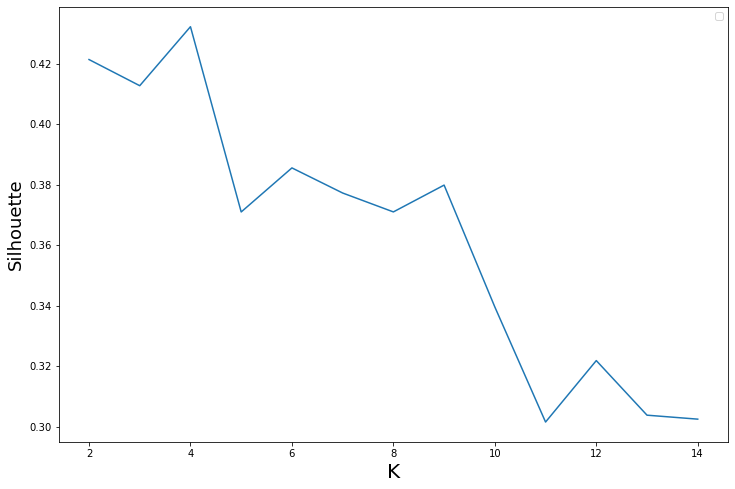

In [60]:
# plot indicators
plt.figure(figsize=(12, 8))
plt.plot(range(2, len(sil_list) + 2), sil_list)
plt.xlabel('K', fontsize=20)
plt.ylabel('Silhouette', fontsize=18)
plt.legend()
plt.show()

<p>With the elbow rule and looking at the graphs we see that the best value of K is 4</p>

In [41]:
labels = []
centers=[]
k = 4
kmeans = KMeans(n_clusters=k, n_init=100)
kmeans.fit(ndf)
centers.append(minmax_scaler.inverse_transform(kmeans.cluster_centers_)) # we store the coordinates of the centroids
labels.append(kmeans.labels_) # we store the labels associated with the records
print("SILHOUETTE:",sil_list[k-2])

SILHOUETTE: 0.43221799228639496


In [42]:
cluster_col = 'K_' + str(k) # it contains the name of the column containing the optimal labels
l = np.transpose(labels)
df[cluster_col] = l

In [72]:
df

,TotItem,avgSpent,Nsessions,TotSpent,Max,Min,DistinctItem,MaxItem,MinItem,avgItemSession,MaxSessionsMonth,MeanTimeGap,K_4
Customer ID,,,,,,,,,,,,,
12346.0,26,3.800,5,19.00,4.50,1.00,2,10,1,5.2,12,1.0,1
12358.0,91,35.890,1,35.89,35.89,35.89,9,91,91,91.0,8,0.0,1
12359.0,194,48.570,2,97.14,96.29,0.85,28,182,12,97.0,12,218.0,2
12417.0,149,23.575,2,47.15,46.30,0.85,17,139,10,74.5,10,122.0,2
12422.0,60,6.650,1,6.65,6.65,6.65,5,60,60,60.0,12,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18268.0,142,37.170,1,37.17,37.17,37.17,12,142,142,142.0,11,0.0,1
18271.0,44,26.550,1,26.55,26.55,26.55,8,44,44,44.0,8,0.0,1
18275.0,128,20.650,1,20.65,20.65,20.65,7,128,128,128.0,8,0.0,1


In [81]:
clust_list = list()
for i in range(len(df['K_4'].unique())):
    clust_list.append(df[df['K_4'] == i])

<BarContainer object of 4 artists>

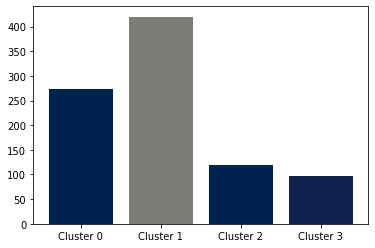

In [102]:
plt.bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list[0]), len(clust_list[1]),len(clust_list[2]),len(clust_list[3])], color=['#00224e','#7d7c78','#01224e','#11224e'])

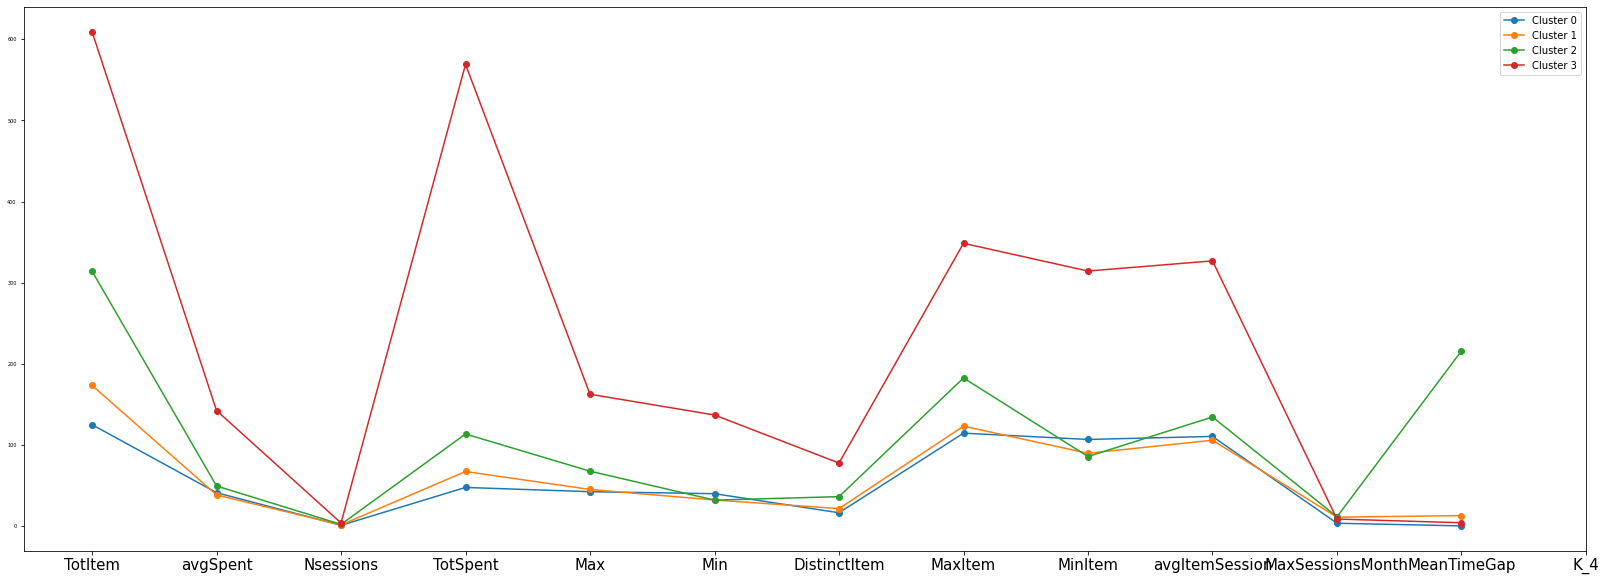

In [56]:
plt.figure(figsize=(28, 10))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.xticks(range(0, len(df.columns)), df.columns, fontsize=15)
plt.legend(fontsize=10)
plt.show()

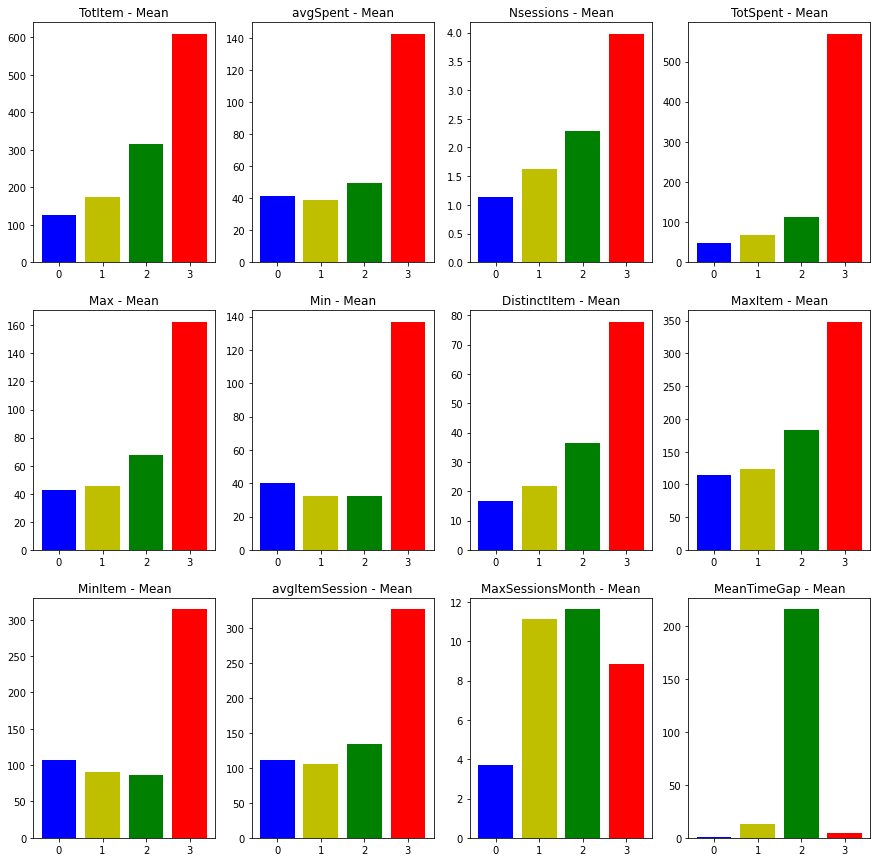

In [105]:
attr = df.columns[:-1]
num_elements = 4
clusters = range(len(clust_list))
fig, axs = plt.subplots(math.ceil(len(attr) / num_elements),num_elements,figsize=(15,15))
for attr_index in range(len(attr)):
    mean_values = []
    for cluster_df in clust_list:
        mean_values.append(cluster_df.describe()[attr[attr_index]][1])
    axs[int(attr_index / num_elements)][attr_index % num_elements].bar(clusters, mean_values, color = ['b','y','g','r'])
    axs[int(attr_index / num_elements)][attr_index % num_elements].set_title(f"{attr[attr_index]} - Mean")

<h2>Dimensionality Reduction using PCA</h2>

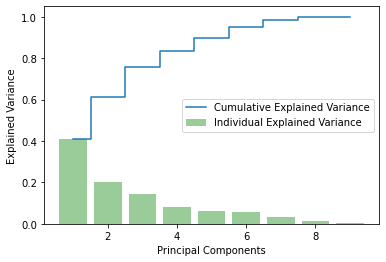

In [39]:
scaler = StandardScaler()
std_cust = scaler.fit_transform(df)

pca = PCA()
pca.fit(std_cust)

plt.step(range(1, df.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, df.shape[1] + 1), pca.explained_variance_ratio_, 
        alpha=0.4, color='g', label='Individual Explained Variance')

plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='center right');


In [45]:
pca = PCA(n_components=2)
pca_cust = pca.fit_transform(std_cust)

<h2>Variables standardization</h2>


<p>xstd = è il vettore standardizzato
x = è il vettore da standardizzare
μ = è la media della variabile
σ = è la deviazione standard della stessa variabile </p>

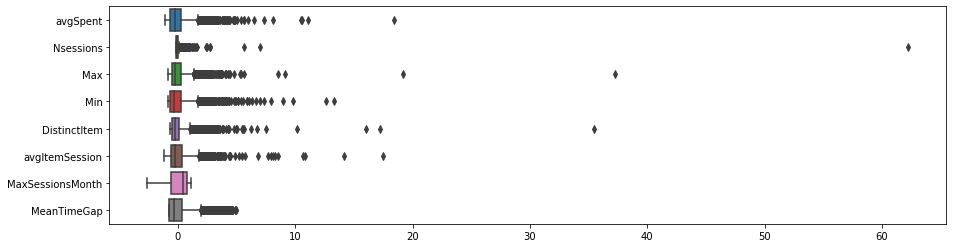

In [11]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df)
scaled_dataframe = pd.DataFrame( scaled_array, columns = df.columns )
plt.figure(figsize = (15,4))
sns.boxplot(data = scaled_dataframe, orient = "h")
plt.show()

In [12]:
scaled_dataframe.describe()

,avgSpent,Nsessions,Max,Min,DistinctItem,avgItemSession,MaxSessionsMonth,MeanTimeGap
count,4.082000e+03,4.082000e+03,4.082000e+03,4.082000e+03,4.082000e+03,4.082000e+03,4.082000e+03,4.082000e+03
mean,1.237510e-16,7.934001e-17,-8.061492e-17,1.245125e-16,-6.027080e-17,3.129948e-16,-2.795956e-17,3.055017e-17
std,1.000123e+00,1.000123e+00,1.000123e+00,1.000123e+00,1.000123e+00,1.000123e+00,1.000123e+00,1.000123e+00
min,-1.101294e+00,-1.141326e-01,-8.420470e-01,-8.547649e-01,-6.182893e-01,-1.131752e+00,-2.577314e+00,-7.663837e-01
25%,-6.248354e-01,-1.141326e-01,-5.058942e-01,-6.532187e-01,-4.723146e-01,-6.151343e-01,-5.667529e-01,-7.663837e-01
50%,-2.517625e-01,-7.903998e-02,-2.143340e-01,-3.088157e-01,-2.701959e-01,-2.387413e-01,4.385275e-01,-2.892936e-01
75%,3.175473e-01,-8.854816e-03,2.391741e-01,2.960831e-01,1.452704e-01,3.590592e-01,7.736209e-01,3.375260e-01
max,1.845803e+01,6.224538e+01,3.724317e+01,1.329754e+01,3.545991e+01,1.752553e+01,1.108714e+00,4.958697e+00


<h1>DBSCAN</h1>

In [13]:
import numpy as np # For data management
import pandas as pd # For data management

import seaborn as sns # For data visualization and specifically for pairplot()
import matplotlib.pyplot as plt # For data visualization

from sklearn import datasets # To import the sample dataset
from sklearn.preprocessing import StandardScaler # To transform the dataset
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning

<p>Il DBSCAN è un algoritmo di clustering che fa parte della categoria dei cosiddetti density-based: individua zone dello spazio delle feature in cui la densità dei puntiè maggiore. 
Tutte quelle osservazioni vicine tra loro vengono raggruppate in un cluster. Quelle che invece sembrano isolate sono etichettate come noise o rumore.
Il DBSCAN necessita di due iperparametri:

ε : che corrisponde alla distanza all'interno della quale ricercare punti vicini
n : che corrisponde al numero minimo di punti affinchè si formi un cluster
    
DBSCAN cerca tutti quei cluster i cui punti sono un numero maggiore o uguale ad n e distanti tra loro meno di ε.

</p>

In [14]:
df.shape

(4082, 8)

In [11]:
#vedo quanti elementi vuoti abbiamo
df.isnull().sum()

Customer ID         0
avgSpent            0
Nsessions           0
TotSpent            0
Max                 0
Min                 0
DistinctItem        0
MaxItem             0
MinItem             0
avgItemSession      0
MaxSessionsMonth    0
MeanTimeGap         0
dtype: int64

<p> Inizializzo il DBSCAN</p>

In [15]:
dbscan_model = DBSCAN( eps = 0.7, min_samples = 10)

<h3>Fitting</h3>

In [16]:
dbscan_model.fit(scaled_dataframe)


DBSCAN(eps=0.7, min_samples=10)

In [17]:
labels = dbscan_model.labels_
labels

array([ 0,  0, -1, ...,  0,  0, -1], dtype=int64)

In [18]:
df["LABEL"] = labels

In [19]:
df.head()

,avgSpent,Nsessions,Max,Min,DistinctItem,avgItemSession,MaxSessionsMonth,MeanTimeGap,LABEL
Customer ID,,,,,,,,,
12347.0,51.731667,6,92.67,13.54,82,275.333333,10,55.600000,0
12348.0,0.850000,2,0.85,0.85,2,22.000000,5,99.000000,0
12349.0,200.750000,1,200.75,200.75,64,547.000000,11,0.000000,-1
12350.0,25.300000,1,25.30,25.30,16,196.000000,2,0.000000,0
12352.0,30.644286,7,53.20,12.55,50,71.714286,9,44.666667,0


<h3>Cluster Visualization</h3>

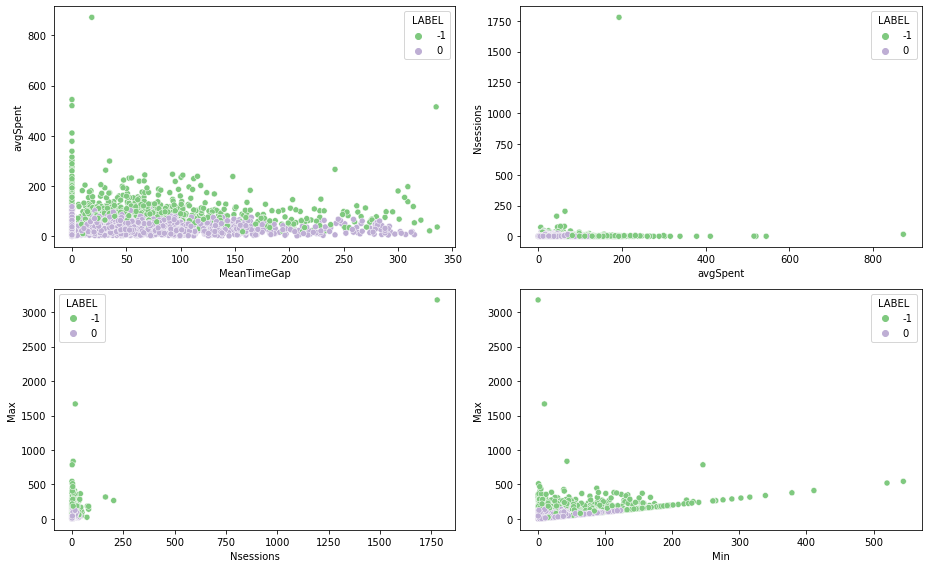

In [20]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (13,8))

sns.scatterplot(x = "MeanTimeGap", y = "avgSpent", data = df, hue = "LABEL", palette = "Accent", ax = ax1)
sns.scatterplot(x = "avgSpent", y = "Nsessions", data = df, hue = "LABEL", palette = "Accent", ax = ax2)
sns.scatterplot(x = "Nsessions", y = "Max", data = df, hue = "LABEL", palette = "Accent", ax = ax3)
sns.scatterplot(x = "Min", y = "Max", data = df, hue = "LABEL", palette = "Accent", ax = ax4)

plt.tight_layout()
plt.show()

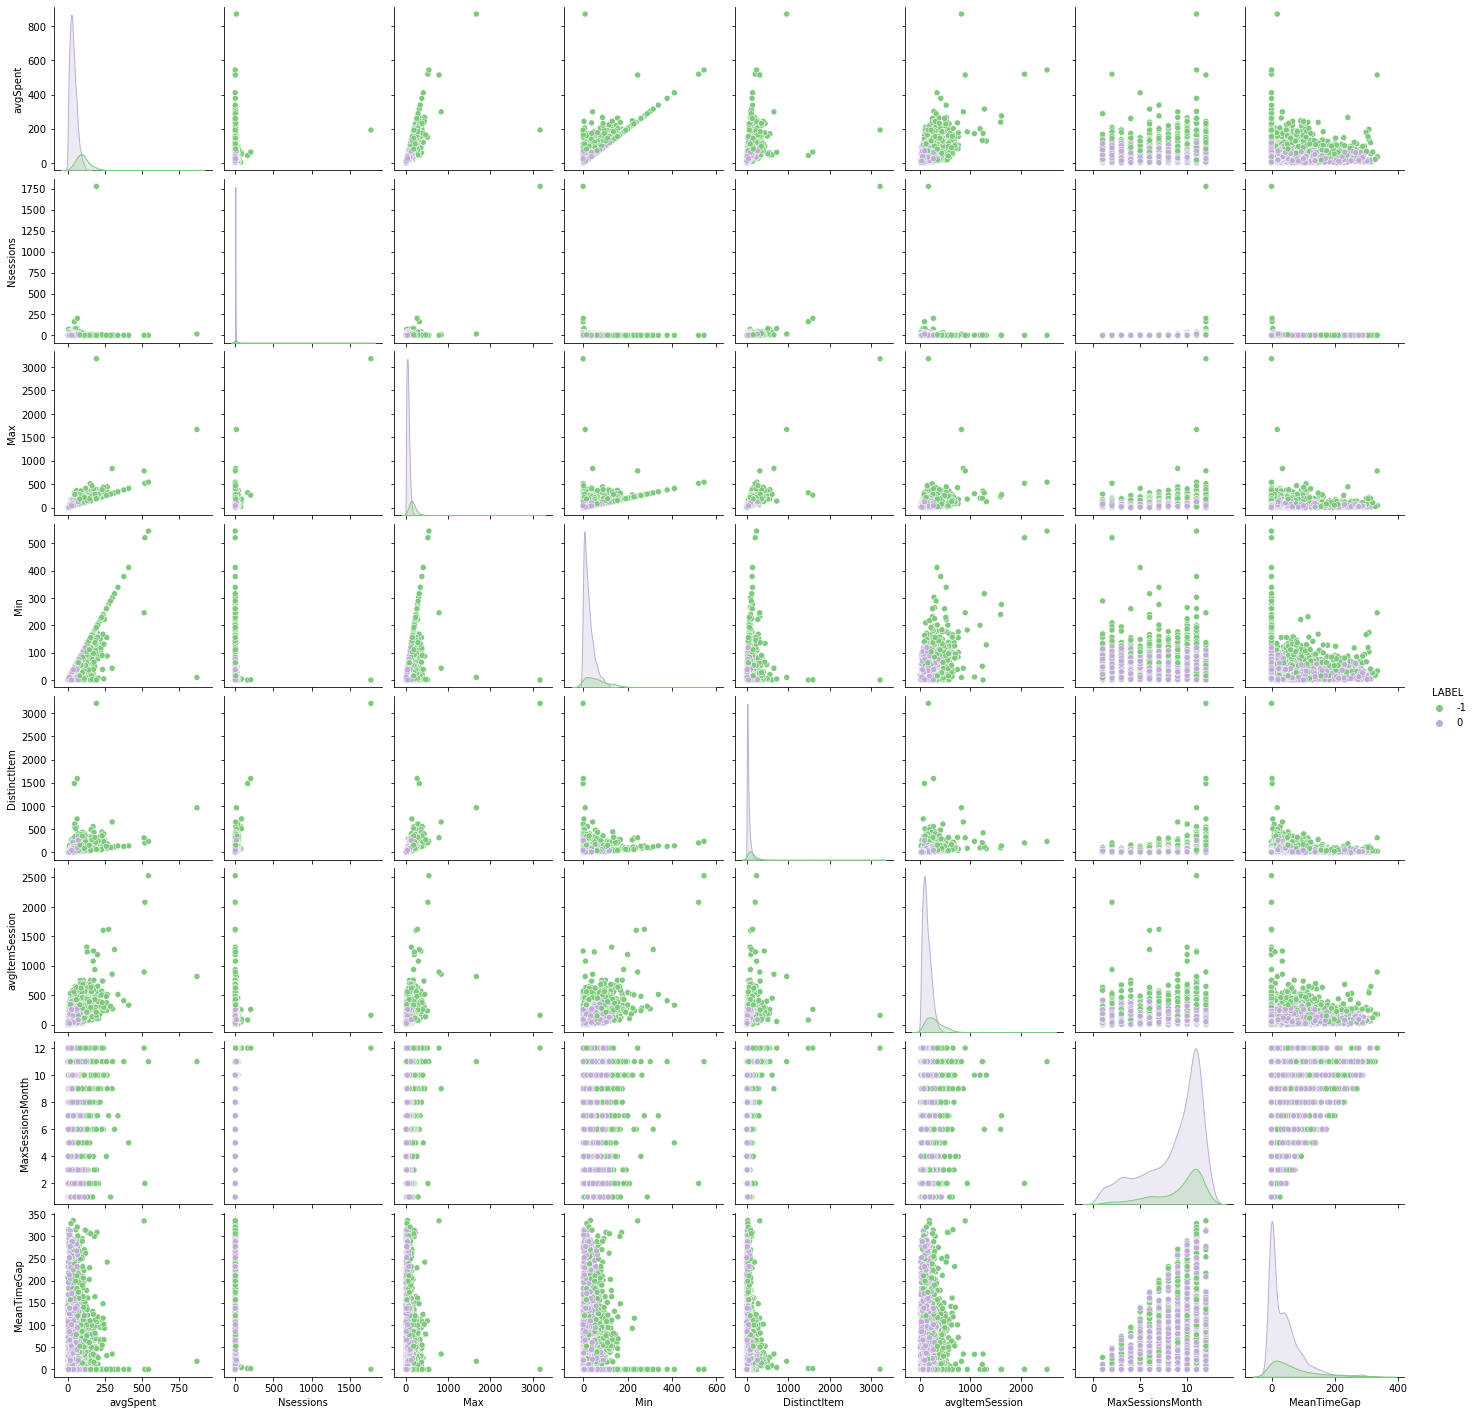

In [21]:
sns.pairplot(data = df, hue = "LABEL", palette = "Accent")
plt.show()

<h3> Evaluation Performance </h3>

In [22]:
eps_to_test = [round(eps,1) for eps in np.arange(0.1, 2, 0.1)]
min_samples_to_test = range(5, 50, 5)

print("EPS:", eps_to_test)
print("MIN_SAMPLES:", list(min_samples_to_test))

EPS: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9]
MIN_SAMPLES: [5, 10, 15, 20, 25, 30, 35, 40, 45]


In [23]:
#Verrà eseguita prima la clusterizzazione e poi il calcolo delle metriche:
#Distanza media tra i noise points e i 6 punti più vicini (6-NN)
#Numero di cluster che vengono individuati 

def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log ==========================================================================
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [24]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)


In [29]:
#grid search
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, scaled_dataframe, iter_)
        
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.1 and min_samples =   5 | 0.512   23
  2 | Tested with eps = 0.1 and min_samples =  10 | 0.496    1
  3 | Tested with eps = 0.1 and min_samples =  15 | 0.495    0
  4 | Tested with eps = 0.1 and min_samples =  20 | 0.495    0
  5 | Tested with eps = 0.1 and min_samples =  25 | 0.495    0
  6 | Tested with eps = 0.1 and min_samples =  30 | 0.495    0
  7 | Tested with eps = 0.1 and min_samples =  35 | 0.495    0
  8 | Tested with eps = 0.1 and min_samples =  40 | 0.495    0
  9 | Tested with eps = 0.1 and min_samples =  45 | 0.495    0
 10 | Tested with eps = 0.2 and min_samples =   5 | 0.572   36
 11 | Tested with eps = 0.2 and min_samples =  10 | 0.527   12
 12 | Tested with eps = 0.2 and min_samples =  15 | 0.505    4
 13 | Tested with eps = 0.2 and min_samples =  20 | 0.498    1
 14 | Tested with eps = 0.2 and min_samples =  25

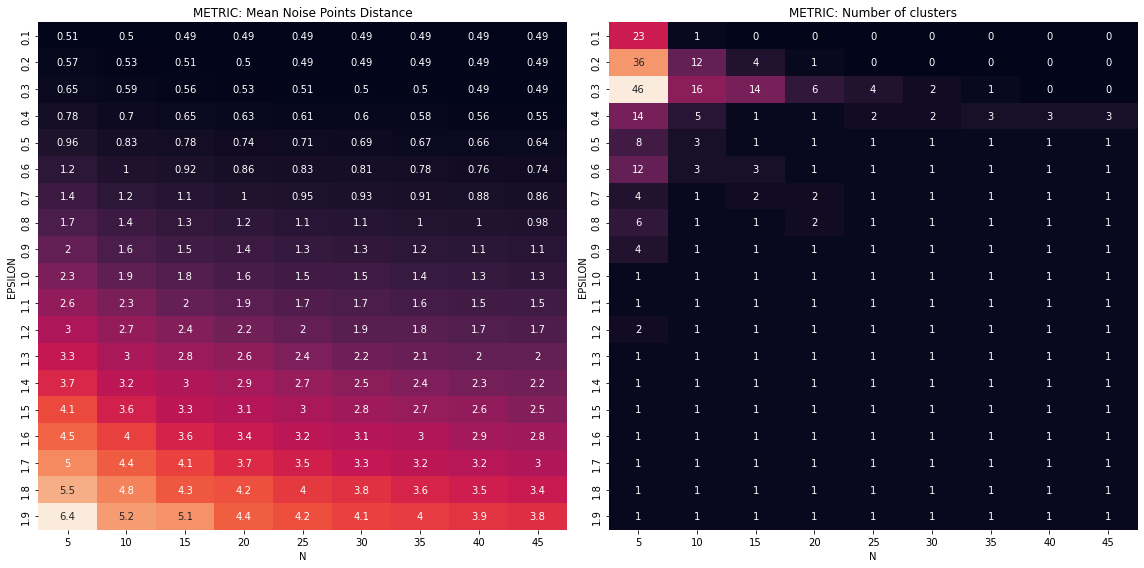

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [163]:
###################################################
clust_list = list()
for i in range(len(df['LABEL'].unique())):
    clust_list.append(df[df['LABEL'] == i])
plt.bar(['Cluster 0','Cluster 1','Cluster 2','Cluster 3'], [len(clust_list[0]), len(clust_list[1]),len(clust_list[2]),len(clust_list[3])], color=['#00224e','#7d7c78','#01224e','#11224e'])

KeyError: 'LABEL'

<h3> ALTRO METODO </h3>

In [156]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

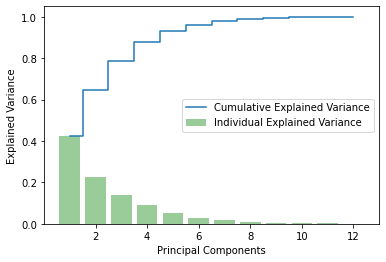

In [157]:
scaler = StandardScaler()
std_customer_profile = scaler.fit_transform(df)

pca = PCA()
pca.fit(std_customer_profile)

plt.step(range(1, df.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, df.shape[1] + 1), pca.explained_variance_ratio_, 
        alpha=0.4, color='g', label='Individual Explained Variance')

plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc='center right');

plt.savefig('D:/Desktop/DataMining/cust_pca.png')

<p>The graph shows the amount of variance captured depending on the number of components we include. A rule of thumb is to preserve around 80% of the variance. So, in this instance, we decide to keep 2 components.
</p>

In [158]:
pca = PCA(n_components=2)
pca_customer_profile = pca.fit_transform(std_customer_profile)

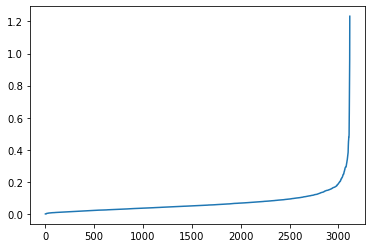

In [164]:
knn = NearestNeighbors(n_neighbors=6)
nbrs = knn.fit(pca_customer_profile)
distances, indices = nbrs.kneighbors(pca_customer_profile)
distances = np.sort(distances, axis=0)[:, 1]
plt.plot(distances);

plt.savefig('D:/Desktop/DataMining/cust_knn.png')

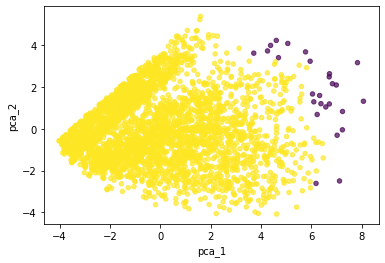

In [165]:
dbscan = DBSCAN(eps=0.8, min_samples=15)
clusters_customers = dbscan.fit_predict(pca_customer_profile)
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(*pca_customer_profile.T, c=clusters_customers, s=20, alpha=0.7);

plt.savefig('D:/Desktop/DataMining/cust_dbscan.png')

In [161]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)

,-1,0
CustomersNb,273,2845


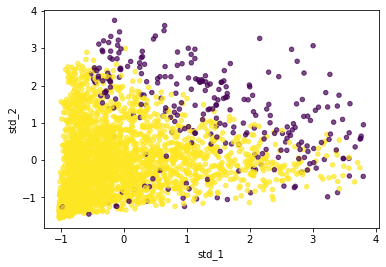

In [162]:
#no pca
plt.xlabel('std_1')
plt.ylabel('std_2')
plt.scatter(std_customer_profile[:, 0], std_customer_profile[:, 1], c=clusters_customers, s=20, alpha=0.7);

In [151]:
customer_profile_dbscan = df.copy(deep=True)
customer_profile_dbscan['cluster'] = clusters_customers
customer_profile_dbscan['cluster'] = customer_profile_dbscan['cluster']
customer_profile_dbscan

,TotItem,avgSpent,Nsessions,TotSpent,Max,Min,DistinctItem,MaxItem,MinItem,avgItemSession,MaxSessionsMonth,MeanTimeGap,LABEL,cluster
Customer ID,,,,,,,,,,,,,,
12346.0,44,31.226667,6,187.36,142.31,4.50,25,19,5,7.333333,6,33.0,-1,0
12347.0,759,74.150000,2,148.30,87.69,60.61,67,506,253,379.500000,10,111.0,-1,-1
12348.0,469,8.295000,2,16.59,14.39,2.20,20,373,96,234.500000,12,80.0,-1,0
12351.0,260,36.710000,1,36.71,36.71,36.71,20,260,260,260.000000,11,0.0,-1,0
12352.0,187,20.925000,2,41.85,29.40,12.45,17,110,77,93.500000,12,12.0,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18281.0,92,19.010000,1,19.01,19.01,19.01,10,92,92,92.000000,11,0.0,0,0
18283.0,315,69.536667,6,417.22,110.15,14.30,152,102,16,52.500000,11,58.4,-1,0
18284.0,215,38.140000,1,38.14,38.14,38.14,20,215,215,215.000000,4,0.0,0,0


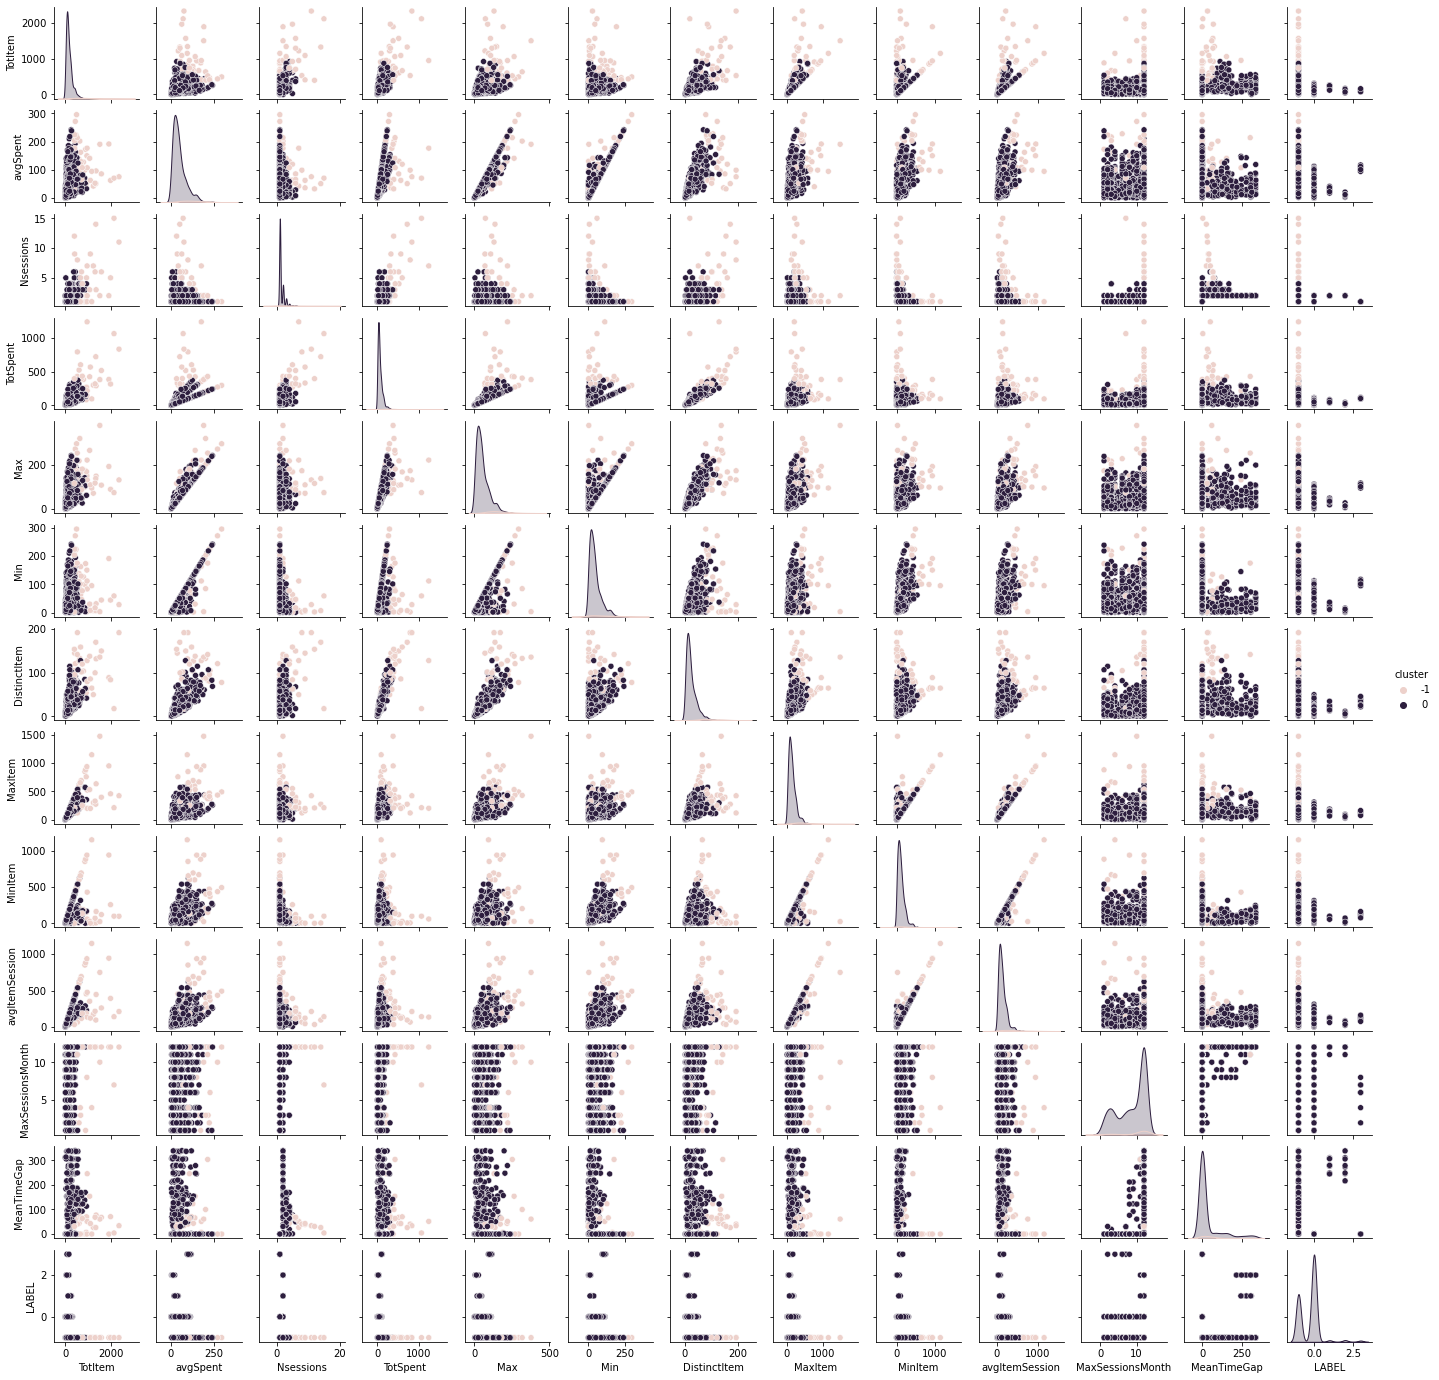

In [84]:
sns.pairplot(customer_profile_dbscan, hue='cluster', diag_kind='kde', height=1.5);

<h3> Agglomerative Clustering </h3>

In [33]:
from sklearn.cluster import AgglomerativeClustering

In [42]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

<p>The linkage criterion determines which distance to use between sets of observation. The algorithm will merge the pairs of cluster that minimize this criterion:

Ward minimizes the euclidean distance of the clusters being merged (is the hierarchical analogue of K-means, so it can be used to initialize it)
strength: less susceptible to noise and outliers
limitations: biased towards globular clusters
single or maximum linkage uses the minimum of the distances between all observations of the two sets
strength: can handle non-elliptical shapes
limitations: sensitive to noise and outliers
complete or maximum linkage uses the maximum distances between all observations of the two sets
strength: less susceptible to noise and outliers
limitations: tends to break large clusters, biased towards globular clusters
average linkage is a compromise between single and complete linkage by using the average of the distances of each observation of the two sets
strength: less susceptible to noise and outliers
limitations: biased towards globular clusters </p>

In [46]:
ward = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')  # setting distance_threshold=0 ensures we compute the full tree
clusters_customers = ward.fit_predict(pca_cust)

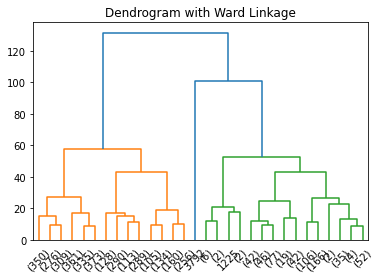

In [48]:
plt.title('Dendrogram with Ward Linkage')
plot_dendrogram(ward, truncate_mode='lastp')  # plot the last p non-singleton clusters formed in the linkage

plt.savefig('D:/Desktop/DataMining/ward-link_2011.png')

In [49]:
#two clusters
ward = AgglomerativeClustering(distance_threshold=None, n_clusters=2, linkage='ward')
clusters_customers = ward.fit_predict(pca_cust)

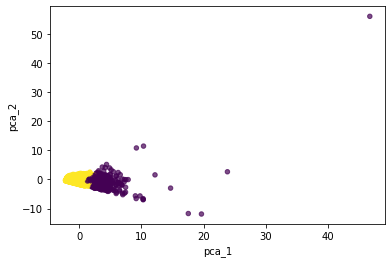

In [52]:
plt.xlabel('pca_1')
plt.ylabel('pca_2')
plt.scatter(*pca_cust.T, c=clusters_customers, s=20, alpha=0.7);

In [53]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns=['CustomersNb']).T.sort_index(axis=1)


,0,1
CustomersNb,603,3479


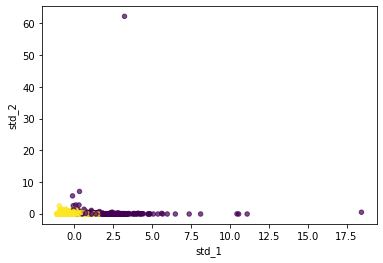

In [55]:
#NO PCA
plt.xlabel('std_1')
plt.ylabel('std_2')
plt.scatter(std_cust[:, 0], std_cust[:, 1], c=clusters_customers, s=20, alpha=0.7);


In [56]:
customer_ward = df.copy(deep=True)
customer_ward['cluster'] = clusters_customers
customer_ward['cluster'] = customer_ward['cluster']
customer_ward

,avgSpent,Nsessions,Max,Min,DistinctItem,avgItemSession,MaxSessionsMonth,MeanTimeGap,LABEL,cluster
Customer ID,,,,,,,,,,
12347.0,51.731667,6,92.67,13.54,82,275.333333,10,55.600000,0,1
12348.0,0.850000,2,0.85,0.85,2,22.000000,5,99.000000,0,1
12349.0,200.750000,1,200.75,200.75,64,547.000000,11,0.000000,-1,0
12350.0,25.300000,1,25.30,25.30,16,196.000000,2,0.000000,0,1
12352.0,30.644286,7,53.20,12.55,50,71.714286,9,44.666667,0,1
...,...,...,...,...,...,...,...,...,...,...
18281.0,5.460000,1,5.46,5.46,5,52.000000,12,0.000000,0,1
18282.0,11.925000,2,13.08,10.77,8,25.500000,5,85.000000,0,1
18283.0,70.714375,16,124.18,1.25,259,84.562500,11,20.733333,0,1


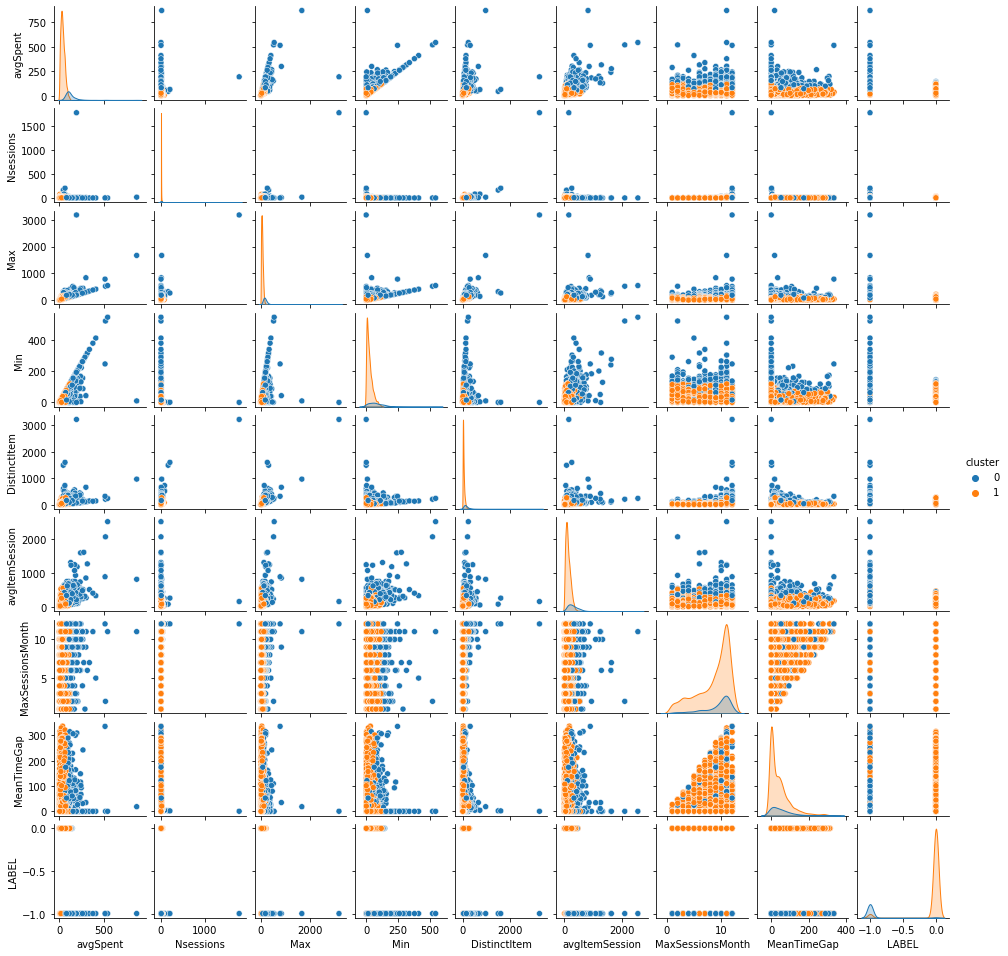

In [57]:
sns.pairplot(customer_ward, hue='cluster', diag_kind='kde', height=1.5);

<p>Agglomerative Clustering</p>
